[View in Colaboratory](https://colab.research.google.com/github/gitpranjal/Web-Scraping-Project/blob/master/StockMarket_Prediction_checkpoint.ipynb)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime

In [0]:
data = pd.read_csv('historical_data.csv')
print data.head()
print '\n Data Types:'
print data.dtypes

  symbol    date_txn    open     low    high  close_price     volume  lead_1  \
0    SPY  11/10/2015  207.51  207.19  208.60       208.55   71844000  207.67   
1    SPY  11/11/2015  208.88  207.66  208.94       207.67   67251000  204.84   
2    SPY  11/12/2015  206.50  204.82  207.06       204.84  118209400  202.54   
3    SPY  11/13/2015  204.35  202.44  204.67       202.54  145494400  205.62   
4    SPY  11/16/2015  202.32  202.18  205.69       205.62  112996000  205.47   

   lead_5  lead_10         name class_type_of  
0  205.47   209.35  SPDR S&P500       S_P_500  
1  208.73   209.32  SPDR S&P500       S_P_500  
2  208.55   209.56  SPDR S&P500       S_P_500  
3  209.31   208.69  SPDR S&P500       S_P_500  
4  209.07   210.68  SPDR S&P500       S_P_500  

 Data Types:
symbol            object
date_txn          object
open             float64
low              float64
high             float64
close_price      float64
volume             int64
lead_1           float64
lead_5           

In [0]:
data["date_txn"]=data["date_txn"].apply(lambda st: pd.to_datetime(st, format='%m/%d/%Y') )

In [0]:
data=data.set_index("date_txn")

# PREDICTING CLOSING PRICES

In [0]:
ts = data['close_price']
ts.head()

date_txn
2015-11-10    208.55
2015-11-11    207.67
2015-11-12    204.84
2015-11-13    202.54
2015-11-16    205.62
Name: close_price, dtype: float64

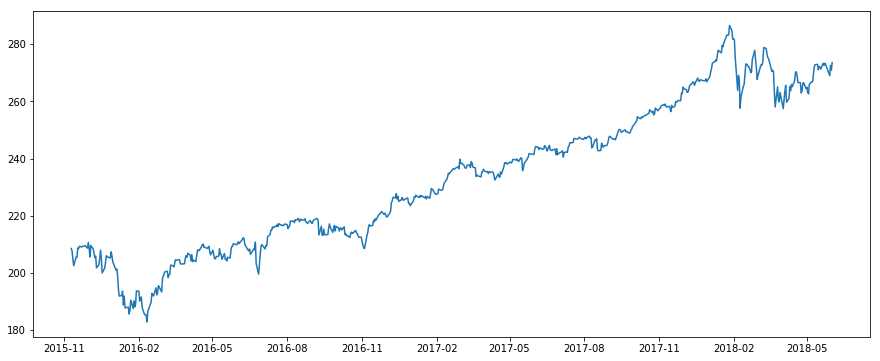

In [0]:
plt.plot(ts)

# Check Stationarity of a Time Series

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

C:\Users\ABCD\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


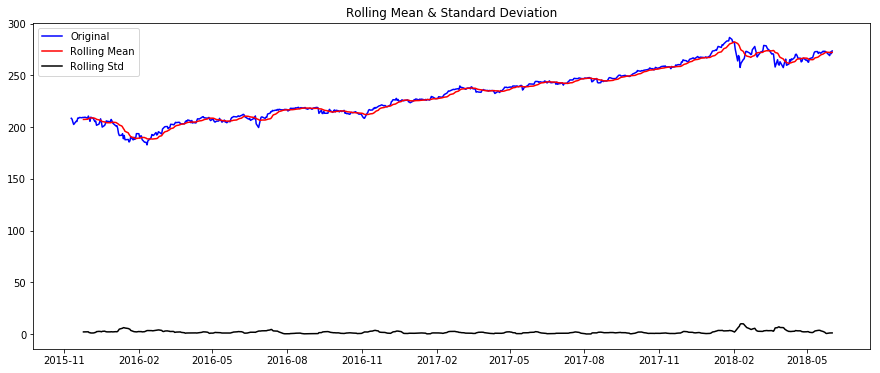

Results of Dickey-Fuller Test:
Test Statistic                  -0.195555
p-value                          0.939049
#Lags Used                       8.000000
Number of Observations Used    634.000000
Critical Value (5%)             -2.866110
Critical Value (1%)             -3.440706
Critical Value (10%)            -2.569203
dtype: float64


In [0]:
test_stationarity(ts)

**Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.**

# Making the Time Series Stationary

**Estimating & Eliminating Trend-By Analysing moving average**
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values.

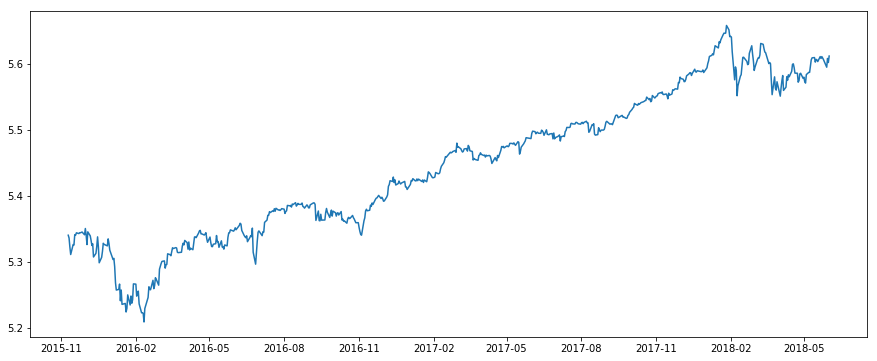

In [0]:
ts_log = np.log(ts)
plt.plot(ts_log)

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


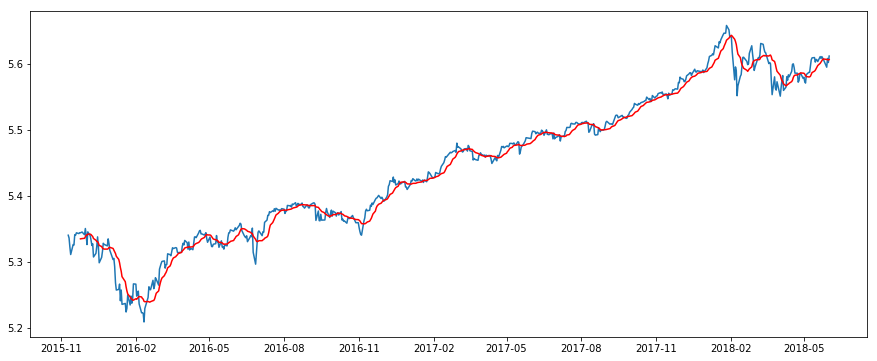

In [0]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


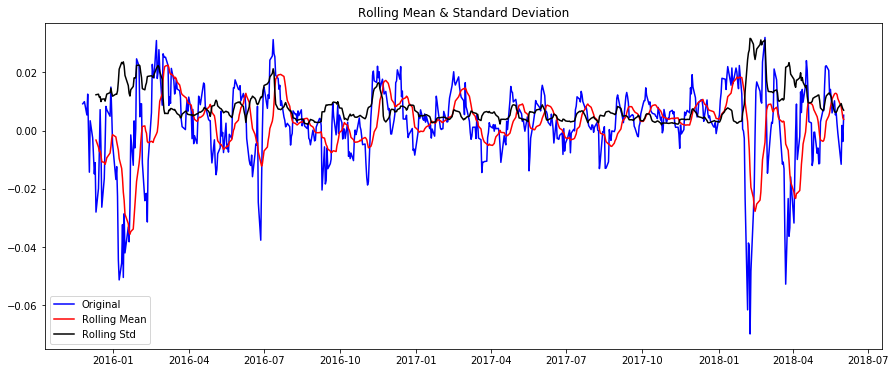

Results of Dickey-Fuller Test:
Test Statistic                -7.477444e+00
p-value                        4.871376e-11
#Lags Used                     8.000000e+00
Number of Observations Used    6.230000e+02
Critical Value (5%)           -2.866190e+00
Critical Value (1%)           -3.440890e+00
Critical Value (10%)          -2.569247e+00
dtype: float64


In [0]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In complex situations like forecasting a stock price, its difficult to come up with a number. So we take a **‘weighted moving average’** where **more recent values are given a higher weight**. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


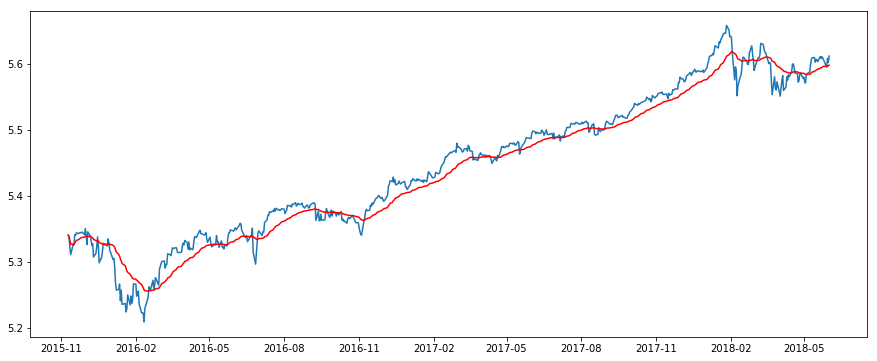

In [0]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


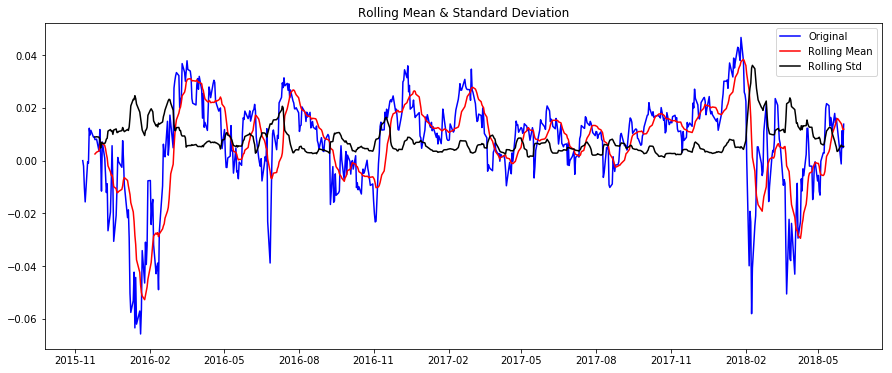

Results of Dickey-Fuller Test:
Test Statistic                  -4.882915
p-value                          0.000038
#Lags Used                       3.000000
Number of Observations Used    639.000000
Critical Value (5%)             -2.866074
Critical Value (1%)             -3.440625
Critical Value (10%)            -2.569184
dtype: float64


In [0]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

# Eliminating Trend and Seasonality

Two ways of removing trend and seasonality:

**Differencing** – taking the differece with a particular time lag

**Decomposition** – modeling both trend and seasonality and removing them from the model.

Differencing One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity

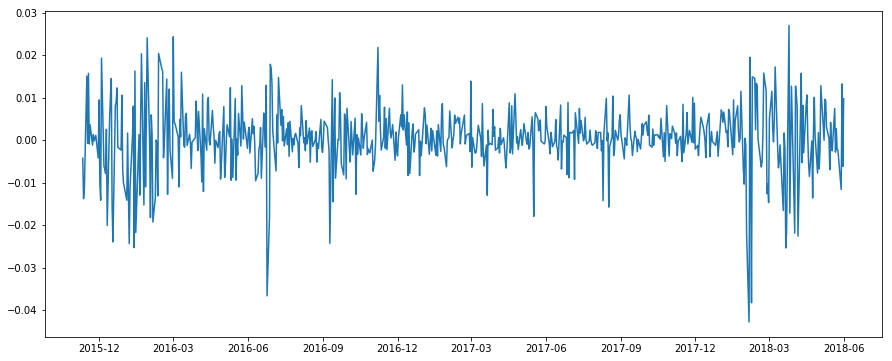

In [0]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


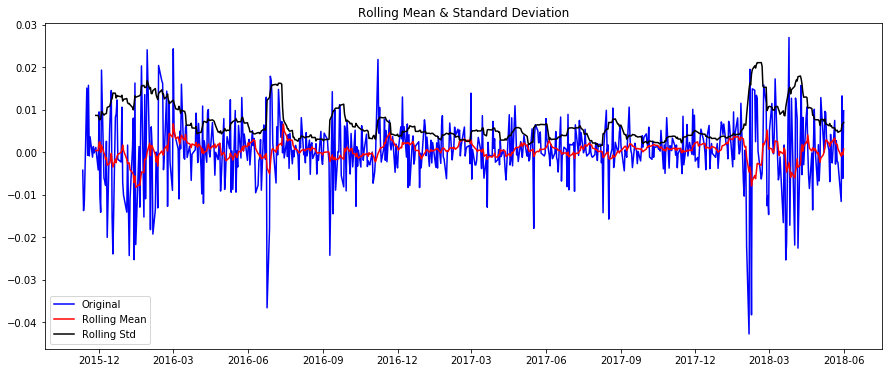

Results of Dickey-Fuller Test:
Test Statistic                 -20.309639
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    640.000000
Critical Value (5%)             -2.866067
Critical Value (1%)             -3.440609
Critical Value (10%)            -2.569181
dtype: float64


In [0]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)


**Decomposing**
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. I’ll skip the statistics and come to the results:

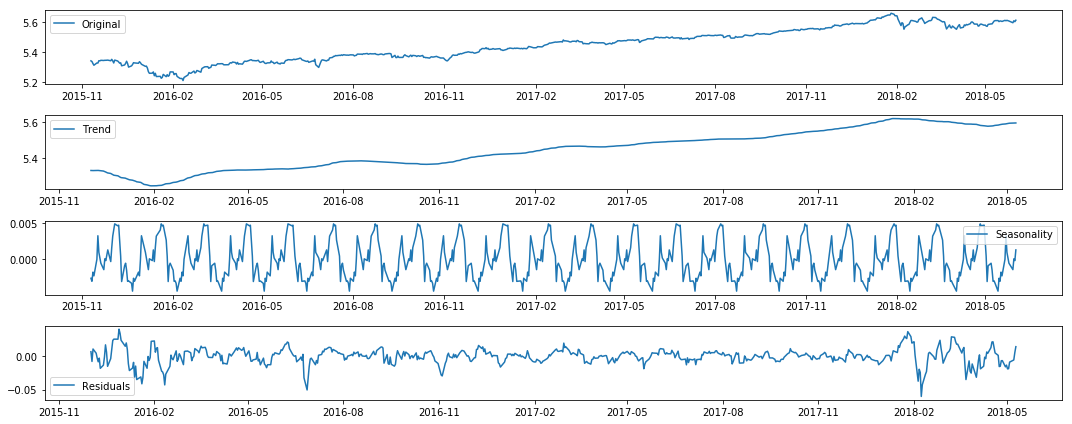

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


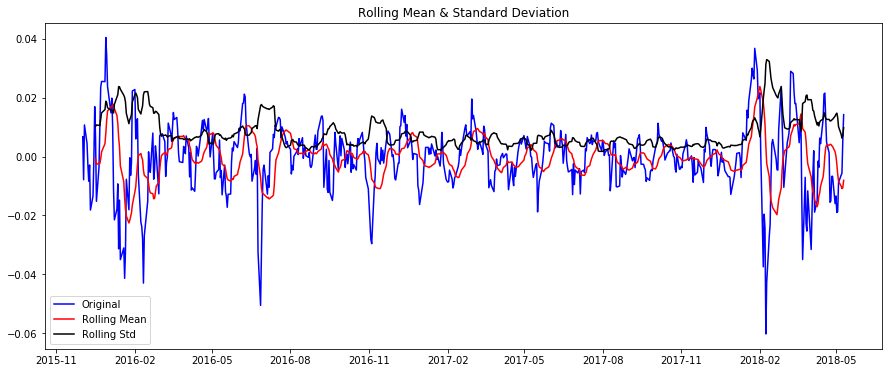

Results of Dickey-Fuller Test:
Test Statistic                -1.016400e+01
p-value                        7.380489e-18
#Lags Used                     7.000000e+00
Number of Observations Used    6.050000e+02
Critical Value (5%)           -2.866329e+00
Critical Value (1%)           -3.441205e+00
Critical Value (10%)          -2.569320e+00
dtype: float64


In [0]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

# Forecasting the Time Series

In [0]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [0]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

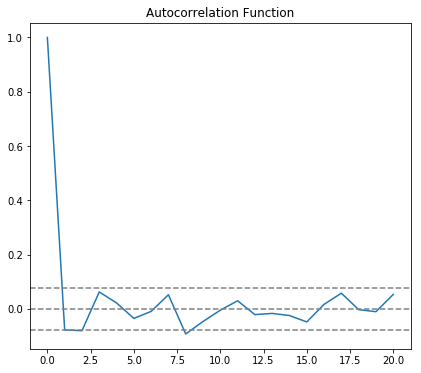

In [0]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

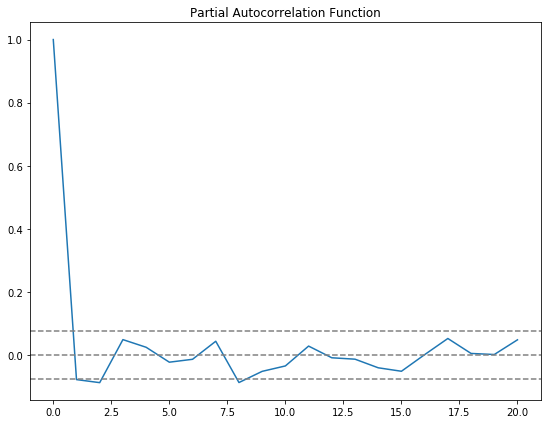

In [0]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [0]:
from statsmodels.tsa.arima_model import ARIMA

# AR Model

Text(0.5,1,'RSS: 0.0386')

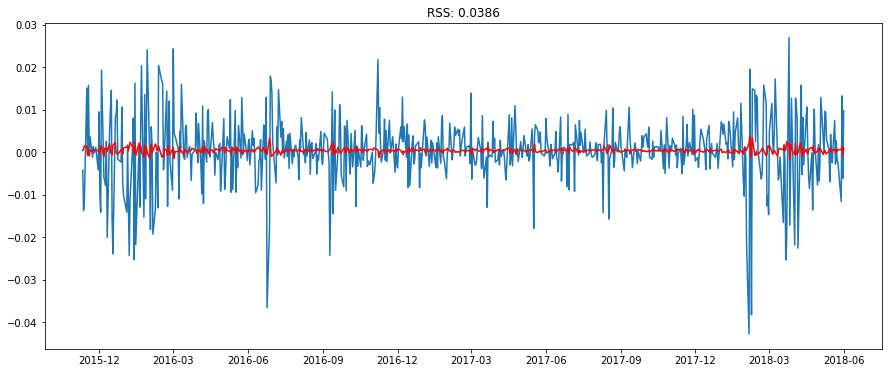

In [0]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

# MA Model

Text(0.5,1,'RSS: 0.0386')

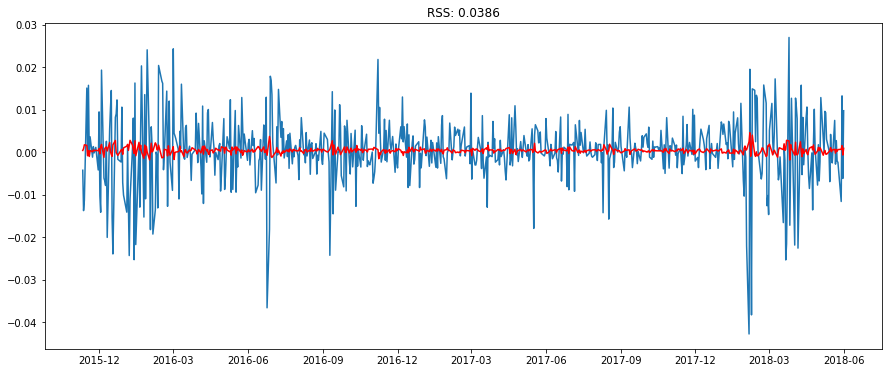

In [0]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

# Combined Model

C:\Users\ABCD\Anaconda2\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ABCD\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 0.0382')

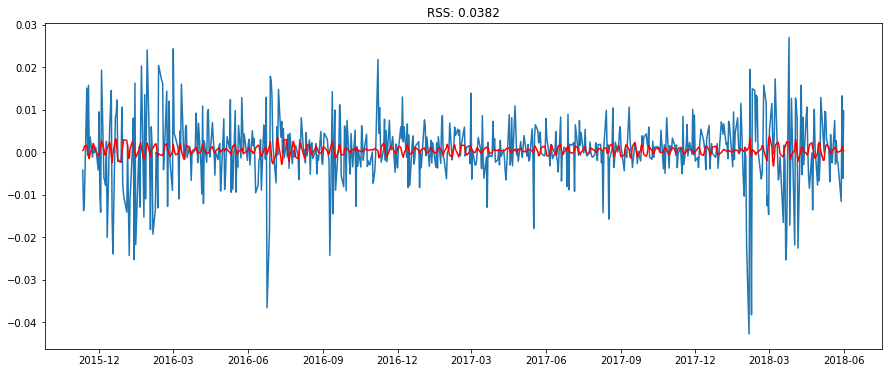

In [0]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

# Taking it back to original scale

**Final Stock closing price Predictions**

In [0]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

data["Predicted Closing Price"]=predictions_ARIMA
predictions_ARIMA.head()


date_txn
2015-11-10    208.550000
2015-11-11    208.638457
2015-11-12    208.775223
2015-11-13    209.058685
2015-11-16    209.406307
dtype: float64

**Predicted Closing Stock prices vs Actual closing Stock prices Plot**

Text(0.5,1,'RMSE: 11.0901')

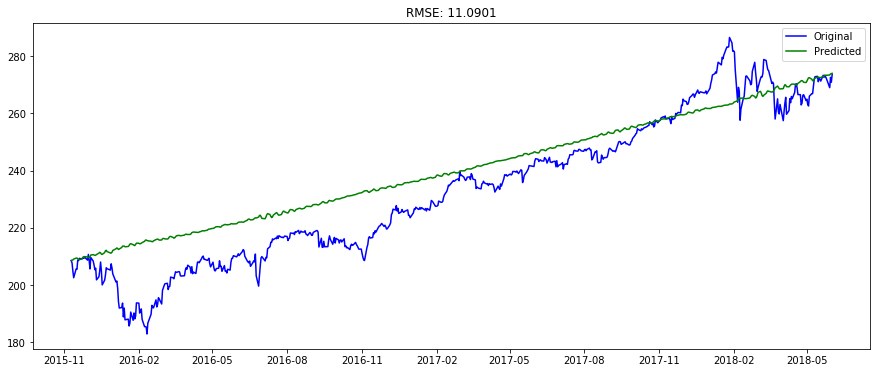

In [0]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts,  color='blue', label='Original')
plt.plot(predictions_ARIMA,  color='green',label='Predicted')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

# PREDICTING VOLUME 

In [0]:
ts = data['volume']
ts.head()

date_txn
2015-11-10     71844000
2015-11-11     67251000
2015-11-12    118209400
2015-11-13    145494400
2015-11-16    112996000
Name: volume, dtype: int64

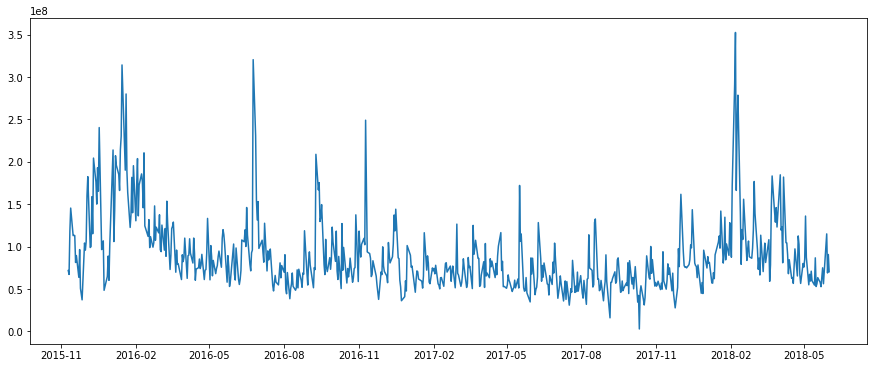

In [0]:
plt.plot(ts)

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


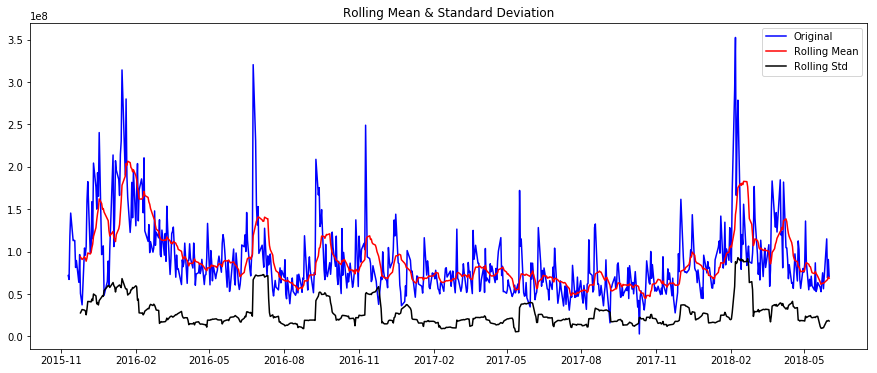

Results of Dickey-Fuller Test:
Test Statistic                  -4.391289
p-value                          0.000308
#Lags Used                       9.000000
Number of Observations Used    633.000000
Critical Value (5%)             -2.866117
Critical Value (1%)             -3.440723
Critical Value (10%)            -2.569207
dtype: float64


In [0]:
test_stationarity(ts)

**Making the Time Series Stationary**

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app


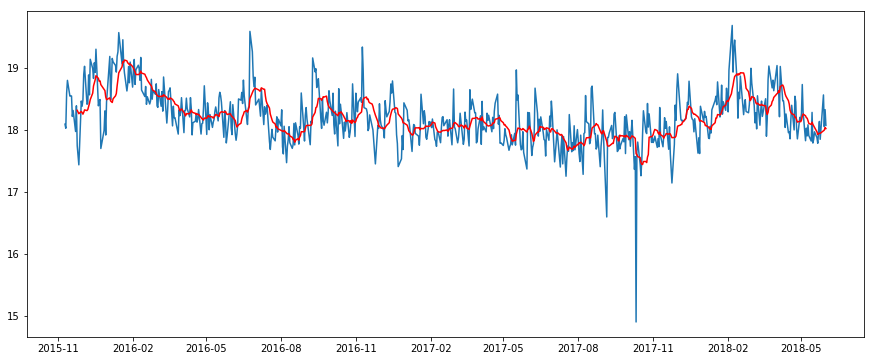

In [0]:
ts_log = np.log(ts)
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


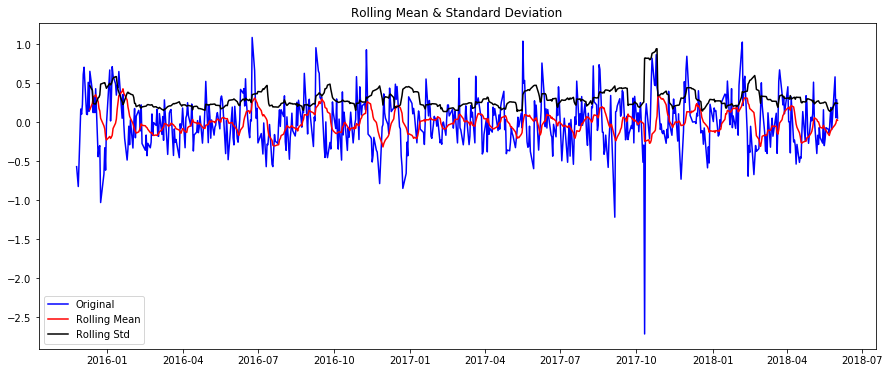

Results of Dickey-Fuller Test:
Test Statistic                -1.010447e+01
p-value                        1.038660e-17
#Lags Used                     1.000000e+01
Number of Observations Used    6.210000e+02
Critical Value (5%)           -2.866205e+00
Critical Value (1%)           -3.440924e+00
Critical Value (10%)          -2.569255e+00
dtype: float64


In [0]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


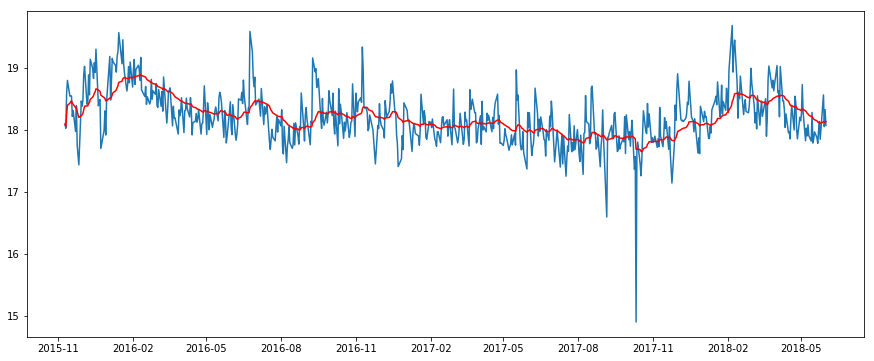

In [0]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


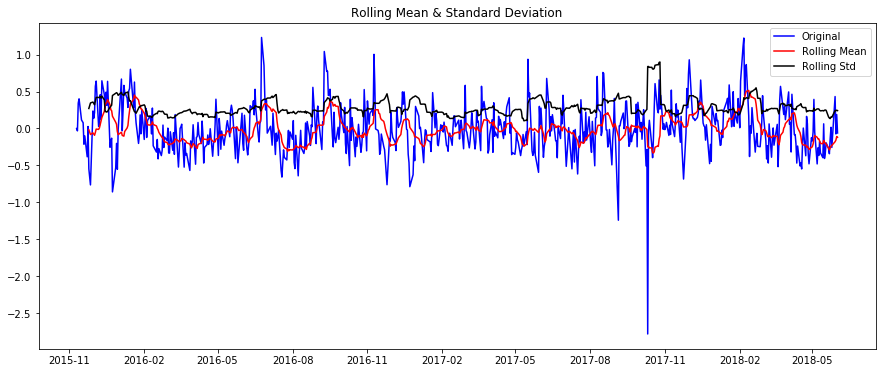

Results of Dickey-Fuller Test:
Test Statistic                -1.156359e+01
p-value                        3.226139e-21
#Lags Used                     1.000000e+00
Number of Observations Used    6.410000e+02
Critical Value (5%)           -2.866060e+00
Critical Value (1%)           -3.440593e+00
Critical Value (10%)          -2.569177e+00
dtype: float64


In [0]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

**Eliminating Trend and Seasonality**

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


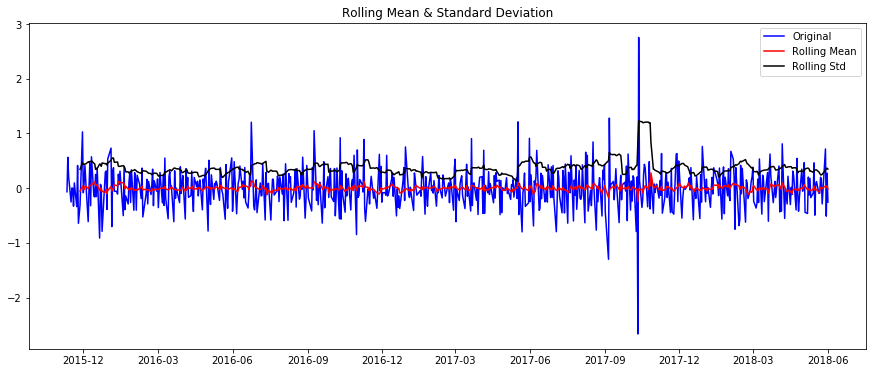

Results of Dickey-Fuller Test:
Test Statistic                -9.364262e+00
p-value                        7.675477e-16
#Lags Used                     1.800000e+01
Number of Observations Used    6.230000e+02
Critical Value (5%)           -2.866190e+00
Critical Value (1%)           -3.440890e+00
Critical Value (10%)          -2.569247e+00
dtype: float64


In [0]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)


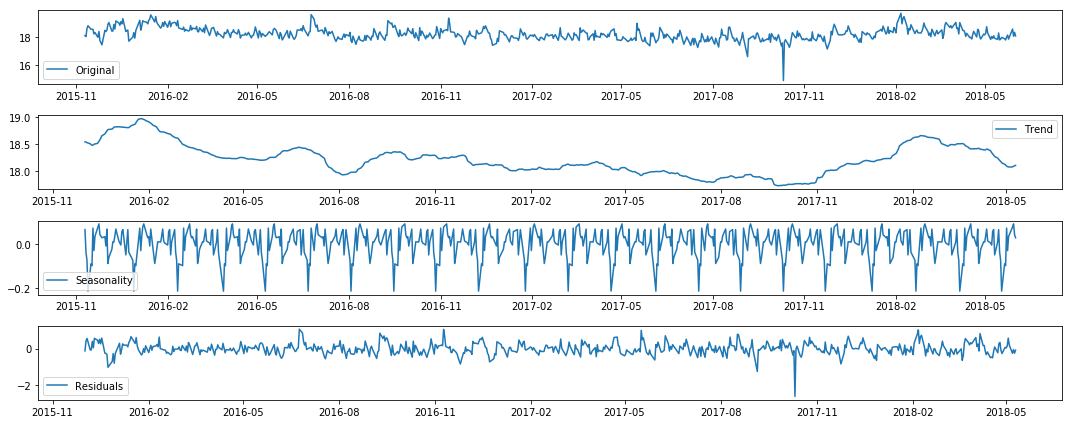

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ABCD\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


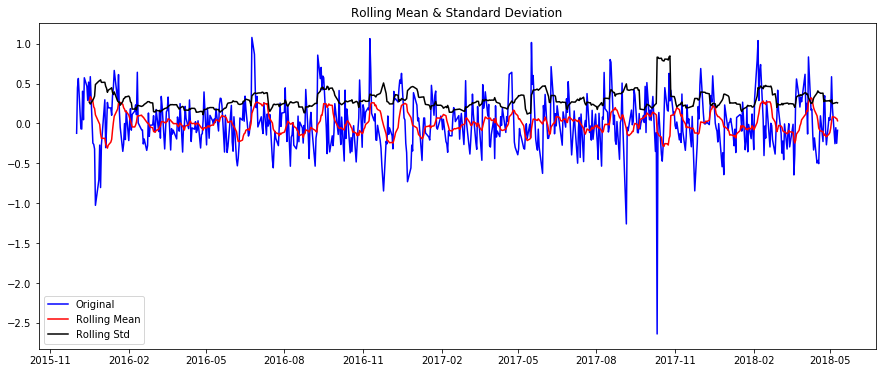

Results of Dickey-Fuller Test:
Test Statistic                -1.082739e+01
p-value                        1.742840e-19
#Lags Used                     1.100000e+01
Number of Observations Used    6.010000e+02
Critical Value (5%)           -2.866361e+00
Critical Value (1%)           -3.441278e+00
Critical Value (10%)          -2.569338e+00
dtype: float64


In [0]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Final forcasting for volume

In [0]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

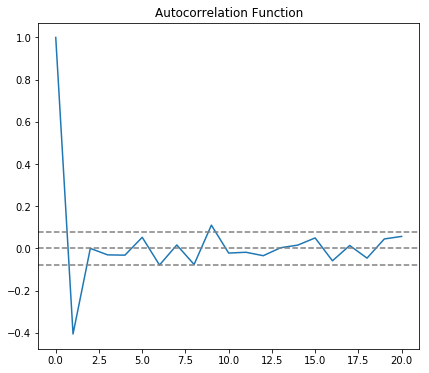

In [0]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

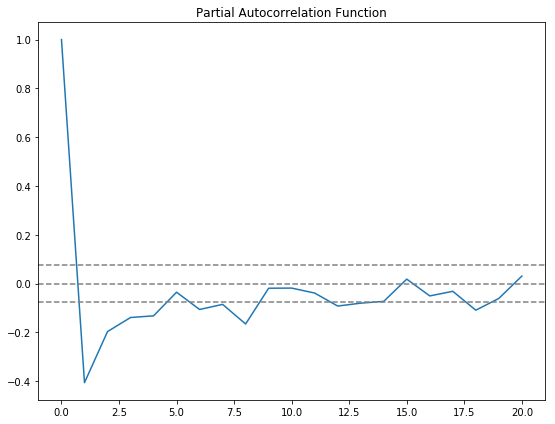

In [0]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**Combined AR and MR models**

Text(0.5,1,'RSS: 66.8929')

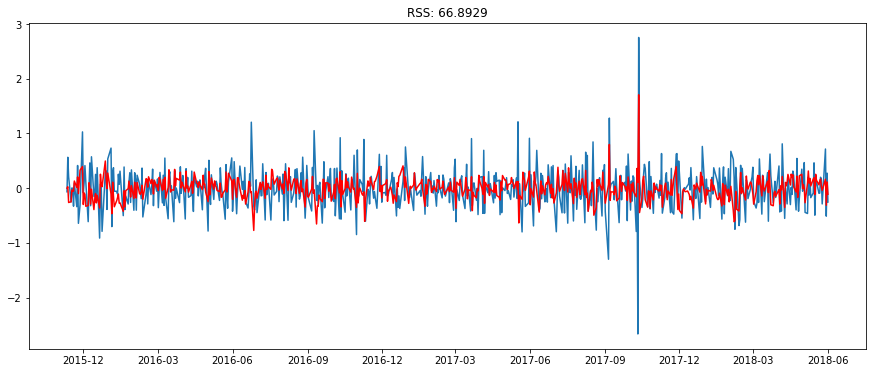

In [0]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

**Taking it back to original scale**

**Predictied Values**

In [0]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

data["Predicted Volume"]=predictions_ARIMA
predictions_ARIMA.head()

date_txn
2015-11-10    7.184400e+07
2015-11-11    7.180679e+07
2015-11-12    7.370164e+07
2015-11-13    5.672518e+07
2015-11-16    4.424178e+07
dtype: float64

**Predicted Volume vs Actual Volume Plot**

Text(0.5,1,'RMSE: 229368028.1659')

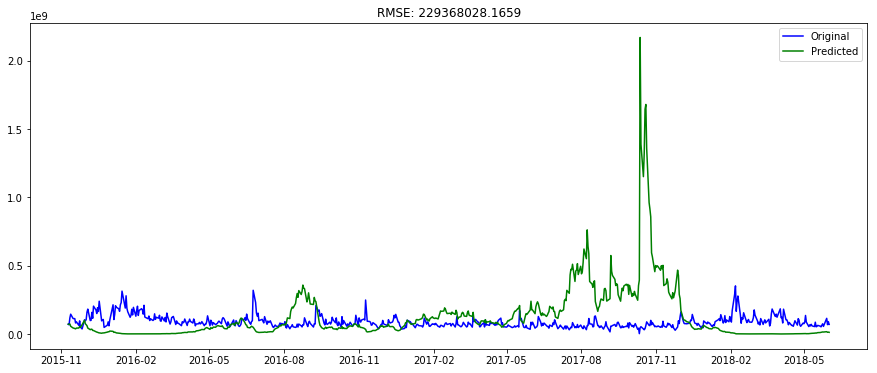

In [0]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts,  color='blue', label='Original')
plt.plot(predictions_ARIMA,  color='green',label='Predicted')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [0]:
from pandas import ExcelWriter

writer = ExcelWriter('StockPrediction.xlsx')
data.to_excel(writer,'Sheet5')
writer.save()

